### Task 3: Customer Segmentation / Clustering

#### Step 1 : Imporing Modules

In [53]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

#### Step 2 : Load and Merge Datasets

In [54]:
# Load the datasets
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

# Merge datasets on CustomerID
data = pd.merge(transactions, customers, on="CustomerID", how="inner")

#### Step 3 : Feature Engineering

In [55]:
# Feature Engineering: Aggregate transaction data by CustomerID
customer_features = (
    data.groupby("CustomerID")
    .agg(
        total_spent=("TotalValue", "sum"),
        avg_transaction_value=("TotalValue", "mean"),
        num_transactions=("TransactionID", "count"),
        avg_quantity=("Quantity", "mean"),
    )
    .reset_index()
)

In [56]:
customer_features.head()

,CustomerID,total_spent,avg_transaction_value,num_transactions,avg_quantity
0,C0001,3354.52,670.904,5,2.400000
1,C0002,1862.74,465.685,4,2.500000
2,C0003,2725.38,681.345,4,3.500000
3,C0004,5354.88,669.360,8,2.875000
4,C0005,2034.24,678.080,3,2.333333


#### Feaure Encoding

In [57]:
# Encode the Region feature
region_encoded = pd.get_dummies(customers.set_index("CustomerID")["Region"], prefix="Region")

# Merge aggregated features with encoded region data
customer_features = customer_features.merge(region_encoded, left_on="CustomerID", right_index=True)

In [58]:
customer_features.head()

,CustomerID,total_spent,avg_transaction_value,num_transactions,avg_quantity,Region_Asia,Region_Europe,Region_North America,Region_South America
0,C0001,3354.52,670.904,5,2.400000,False,False,False,True
1,C0002,1862.74,465.685,4,2.500000,True,False,False,False
2,C0003,2725.38,681.345,4,3.500000,False,False,False,True
3,C0004,5354.88,669.360,8,2.875000,False,False,False,True
4,C0005,2034.24,678.080,3,2.333333,True,False,False,False


#### normalize Features

In [59]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features.iloc[:, 1:]) 

In [60]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.cluster._kmeans")


### Step 4 :  Apply K-Means Clustering

In [61]:
k_values = range(2, 11)
db_scores = []
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    db_scores.append(davies_bouldin_score(scaled_features, labels))
    silhouette_scores.append(silhouette_score(scaled_features, labels))

# Optimal number of clusters using DB Index
optimal_k = k_values[np.argmin(db_scores)]
print(f"Optimal number of clusters (DB Index): {optimal_k}")

Optimal number of clusters (DB Index): 5


In [62]:
# Final K-Means model
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
final_labels = final_kmeans.fit_predict(scaled_features)


In [63]:
# Add cluster labels to the dataframe
customer_features["Cluster"] = final_labels

In [64]:
# Calculate DB Index for final clustering
final_db_index = davies_bouldin_score(scaled_features, final_labels)
print(f"Davies-Bouldin Index for final clustering: {final_db_index:.2f}")

Davies-Bouldin Index for final clustering: 1.07


### Step 5 : Visualization

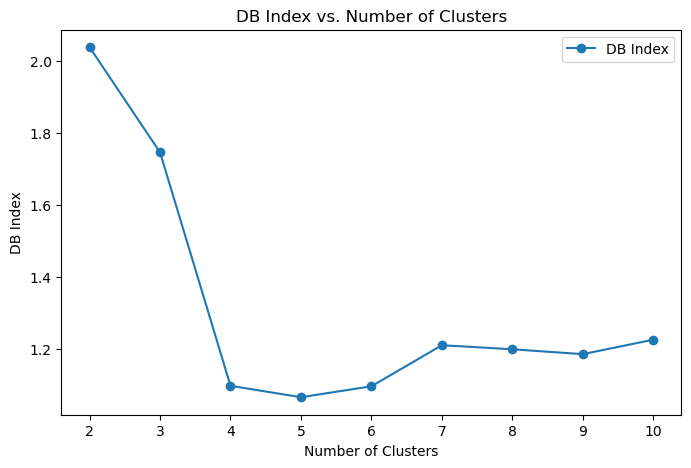

In [65]:
# Visualization: Elbow Method for DB Index
plt.figure(figsize=(8, 5))
plt.plot(k_values, db_scores, marker="o", label="DB Index")
plt.xlabel("Number of Clusters")
plt.ylabel("DB Index")
plt.title("DB Index vs. Number of Clusters")
plt.legend()
plt.show()

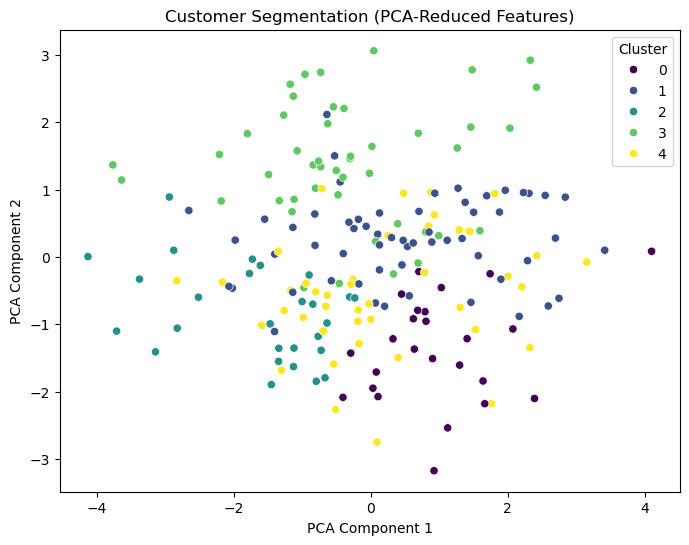

In [66]:
# Visualization: Scatter Plot of Clusters (PCA for dimensionality reduction)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=pca_features[:, 0], 
    y=pca_features[:, 1], 
    hue=customer_features["Cluster"], 
    palette="viridis", 
    legend="full"
)
plt.title("Customer Segmentation (PCA-Reduced Features)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()